# Backtesting on Trade Data

## Import module

In [ ]:
! pip install kaggle
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm
import pickle
from sklearn.preprocessing import StandardScaler
import csv
import time
import itertools
import scipy.stats as ss
! pip install pykalman
from pykalman import KalmanFilter
! pip install mplfinance # vẽ biểu đồ nến
import mplfinance as mpf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

## Loading Trade Data

In [ ]:
! kaggle datasets download landiepnguyen/contract-trading-ethusdt-jan2024 -f 'ETHUSDT_2024-01-08.csv'

Dataset URL: https://www.kaggle.com/datasets/landiepnguyen/contract-trading-ethusdt-jan2024
License(s): unknown
 56% 7.00M/12.4M [00:00<00:00, 71.7MB/s]
100% 12.4M/12.4M [00:00<00:00, 48.9MB/s]


In [ ]:
trade_df = pd.read_csv('/content/ETHUSDT_2024-01-08.csv')
trade_df = trade_df.drop(['id'], axis=1)

In [ ]:
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], unit='ms')
trade_df = trade_df.sort_values(by='timestamp')
trade_df.set_index('timestamp', inplace=True)
resampled_trade_df = trade_df.resample('60s').last().ffill()

In [ ]:
# export file for Streamlit app
resampled_trade_df.reset_index(inplace=True)
resampled_trade_df.to_csv("resampled_trade_df.csv", index=False)
resampled_trade_df.set_index('timestamp', inplace=True)

In [ ]:
resampled_trade_df.head()

,price,volume,side
timestamp,,,
2024-01-08 00:00:00,2219.41,0.00045,buy
2024-01-08 00:01:00,2219.81,0.07472,buy
2024-01-08 00:02:00,2221.30,0.04501,buy
2024-01-08 00:03:00,2220.10,0.11000,buy
2024-01-08 00:04:00,2221.20,0.11775,buy


In [ ]:
trade_df = pd.read_csv('/content/ETHUSDT_2024-01-08.csv')
trade_df = trade_df.drop(['id'], axis=1)

trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], unit='ms')
trade_df = trade_df.sort_values(by='timestamp')
trade_df.set_index('timestamp', inplace=True)
resampled_trade_df = trade_df.resample('60s').last().ffill()

In [ ]:
df_ohc = pd.read_csv('/content/openhighclose_ETHUSDT_7d.csv')
df_ohc['start_at'] = pd.to_datetime(df_ohc['start_at'], unit = 's')
df_ohc['close'] = df_ohc['close'] - 1
# only get data from 8th day
df_ohc.drop(df_ohc.loc[df_ohc['start_at'] < '2024-01-08 00:00:00'].index, inplace=True)
# df_ohc.set_index('start_at', inplace=True)
df_ohc.to_csv("openhighclose_ETHUSDT_day8.csv", index=False)

In [ ]:
df_ohc = pd.read_csv('/content/openhighclose_ETHUSDT_day8.csv')
df_ohc

,start_at,symbol,period,open,high,low,close
0,2024-01-08 00:00:00,ETHUSD,1,2222.42,2222.69,2220.07,2219.77
1,2024-01-08 00:01:00,ETHUSD,1,2220.77,2221.61,2220.66,2219.95
2,2024-01-08 00:02:00,ETHUSD,1,2220.95,2222.45,2220.95,2221.41
3,2024-01-08 00:03:00,ETHUSD,1,2222.41,2222.92,2220.89,2220.45
4,2024-01-08 00:04:00,ETHUSD,1,2221.45,2222.29,2221.41,2221.25
...,...,...,...,...,...,...,...
1435,2024-01-08 23:55:00,ETHUSD,1,2332.98,2333.60,2332.69,2332.28
1436,2024-01-08 23:56:00,ETHUSD,1,2333.28,2333.76,2332.98,2332.23
1437,2024-01-08 23:57:00,ETHUSD,1,2333.23,2333.91,2332.96,2332.42
1438,2024-01-08 23:58:00,ETHUSD,1,2333.42,2333.80,2332.78,2331.85


In [ ]:
! kaggle datasets download landiepnguyen/contract-trading-ethusdt-jan2024 -f orderbook_2024_01_08_ETHUSDT.csv

Dataset URL: https://www.kaggle.com/datasets/landiepnguyen/contract-trading-ethusdt-jan2024
License(s): unknown
 95% 111M/117M [00:00<00:00, 161MB/s] 
100% 117M/117M [00:00<00:00, 158MB/s]


In [ ]:
df = pd.read_csv('/content/orderbook_2024_01_08_ETHUSDT.csv', index_col=False)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,bid_price_3,bid_size_3,ask_price_4,ask_size_4,bid_price_4,bid_size_4,ask_price_5,ask_size_5,bid_price_5,bid_size_5
timestamp,,,,,,,,,,,,,,,,,,,,
2024-01-08 00:00:00.631,2221.23,5.87,2221.22,23.72,2221.25,1.69,2221.21,8.61,2221.28,1.38,2221.2,2.03,2221.29,2.25,2221.1,3.6,2221.4,2.03,2221.09,6.0
2024-01-08 00:00:00.729,2221.23,4.52,2221.22,23.72,2221.25,1.69,2221.21,8.61,2221.28,1.38,2221.2,2.03,2221.29,2.25,2221.1,3.6,2221.4,2.03,2221.09,6.0
2024-01-08 00:00:00.829,2221.23,4.52,2221.22,23.72,2221.25,1.69,2221.21,8.61,2221.28,1.38,2221.2,2.03,2221.29,2.25,2221.1,3.6,2221.4,2.03,2221.09,6.0
2024-01-08 00:00:00.929,2221.23,4.52,2221.22,23.72,2221.25,1.69,2221.21,8.61,2221.28,1.38,2221.2,2.03,2221.29,2.25,2221.1,3.6,2221.4,2.03,2221.09,6.0
2024-01-08 00:00:01.030,2221.23,4.52,2221.22,21.97,2221.25,1.69,2221.21,8.61,2221.28,1.38,2221.2,2.03,2221.29,2.25,2221.1,3.6,2221.4,2.03,2221.09,6.0


In [ ]:
resampled_df = df.resample('60s').last().ffill()
resampled_df.reset_index(inplace=True)
resampled_df.drop(resampled_df.loc[resampled_df['timestamp'] > '2024-01-08 23:59:00'].index, inplace=True)
resampled_df.set_index('timestamp', inplace=True)
resampled_df["midprice_1"] = (resampled_df["ask_price_1"] + resampled_df["bid_price_1"]) / 2.0
resampled_df["spread_1"] = resampled_df["ask_price_1"] - resampled_df["bid_price_1"]
resampled_df

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,ask_price_4,ask_size_4,bid_price_4,bid_size_4,ask_price_5,ask_size_5,bid_price_5,bid_size_5,midprice_1,spread_1
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-08 00:00:00,2219.16,7.82,2219.15,6.92,2219.17,1.85,2219.04,0.54,2219.18,3.67,...,2219.19,2.00,2219.02,19.00,2219.20,4.03,2219.00,99.99,2219.155,0.01
2024-01-08 00:01:00,2219.43,2.48,2219.42,15.31,2219.44,0.10,2219.41,0.10,2219.54,2.00,...,2219.55,0.38,2219.32,8.26,2219.57,1.35,2219.31,6.98,2219.425,0.01
2024-01-08 00:02:00,2221.01,22.72,2221.00,28.29,2221.02,5.10,2220.99,0.10,2221.05,0.01,...,2221.11,0.01,2220.86,11.36,2221.13,0.12,2220.85,0.49,2221.005,0.01
2024-01-08 00:03:00,2219.94,15.83,2219.93,31.28,2219.95,0.10,2219.92,2.10,2219.96,0.34,...,2220.00,6.55,2219.80,2.03,2220.03,0.92,2219.72,7.43,2219.935,0.01
2024-01-08 00:04:00,2221.08,21.83,2221.07,27.72,2221.09,0.10,2221.06,0.10,2221.11,0.06,...,2221.13,1.35,2220.95,1.62,2221.14,0.05,2220.92,6.48,2221.075,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08 23:55:00,2331.40,2.21,2331.39,34.70,2331.55,2.00,2331.38,4.66,2331.56,2.00,...,2331.59,1.34,2331.36,4.43,2331.60,2.15,2331.30,1.71,2331.395,0.01
2024-01-08 23:56:00,2331.74,11.93,2331.73,0.23,2331.75,1.47,2331.72,0.10,2331.76,2.00,...,2331.79,2.14,2331.53,0.02,2331.80,2.15,2331.52,8.54,2331.735,0.01
2024-01-08 23:57:00,2331.85,8.42,2331.84,7.75,2331.86,0.10,2331.83,0.10,2331.91,7.25,...,2331.99,4.74,2331.80,2.15,2332.00,2.28,2331.77,10.38,2331.845,0.01


In [ ]:
(resampled_trade_df['price'] == df_ohc['close'] - 1).sum()

13

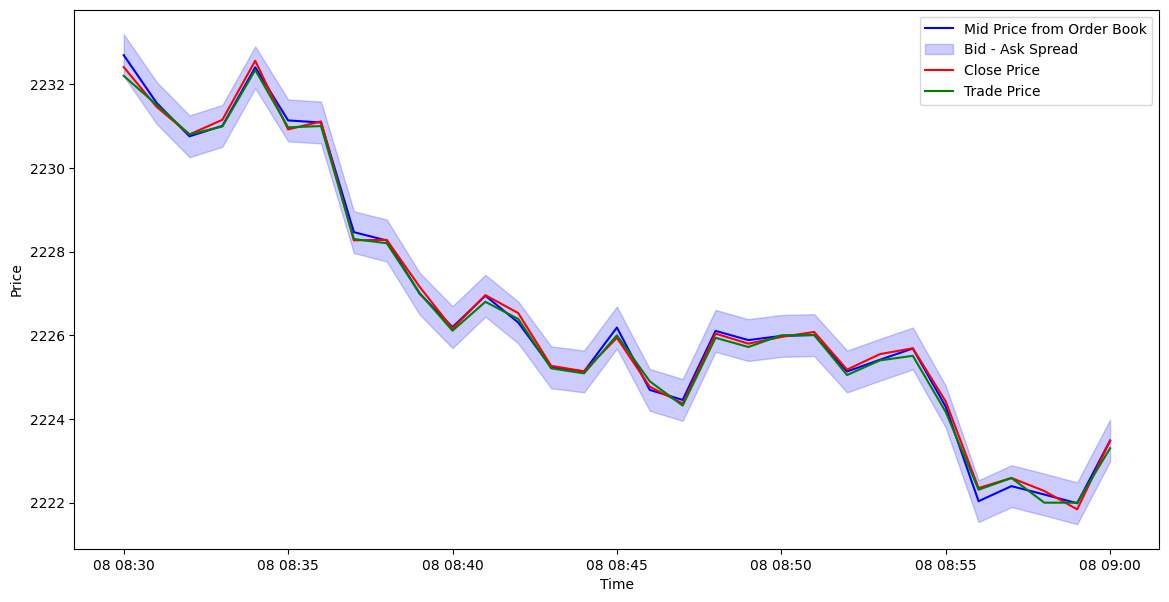

In [ ]:
subset_start = '2024-01-08 08:30:00'
subset_end = '2024-01-08 09:00:00'
subset_close_price = df_ohc['close'][subset_start:subset_end] - 1
subset_resampled_trade_price = resampled_trade_df['price'][subset_start:subset_end]
subset_resampled_df = resampled_df[subset_start:subset_end]

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(subset_resampled_trade_price.index, subset_resampled_df['midprice_1'], label='Mid Price from Order Book', color='blue')
plt.fill_between(subset_resampled_trade_price.index,
                 subset_resampled_df['midprice_1'] - (subset_resampled_df['spread_1'] / 2) * 100,
                 subset_resampled_df['midprice_1'] + (subset_resampled_df['spread_1'] / 2) * 100,
                 color='blue', alpha=0.2, label='Bid - Ask Spread')
plt.plot(subset_resampled_trade_price.index, subset_close_price, label='Close Price', color='red')
plt.plot(subset_resampled_trade_price.index, subset_resampled_trade_price, label='Trade Price', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Loading and Prepare Data for Backtesting

### OHLC Data

In [ ]:
df_ohc = pd.read_csv('/content/openhighclose_ETHUSDT_day8.csv')
df_ohc['start_at'] = pd.to_datetime(df_ohc['start_at'])
df_ohc.set_index('start_at', inplace=True)
df_ohc.head()

,symbol,period,open,high,low,close
start_at,,,,,,
2024-01-08 00:00:00,ETHUSD,1,2222.42,2222.69,2220.07,2219.57
2024-01-08 00:01:00,ETHUSD,1,2220.77,2221.61,2220.66,2219.75
2024-01-08 00:02:00,ETHUSD,1,2220.95,2222.45,2220.95,2221.21
2024-01-08 00:03:00,ETHUSD,1,2222.41,2222.92,2220.89,2220.25
2024-01-08 00:04:00,ETHUSD,1,2221.45,2222.29,2221.41,2221.05


### Order Book Data

In [ ]:
! kaggle datasets download landiepnguyen/contract-trading-ethusdt-jan2024 -f orderbook_2024_01_08_ETHUSDT.csv

Dataset URL: https://www.kaggle.com/datasets/landiepnguyen/contract-trading-ethusdt-jan2024
License(s): unknown
 99% 116M/117M [00:01<00:00, 134MB/s]
100% 117M/117M [00:01<00:00, 119MB/s]


In [ ]:
df = pd.read_csv('/content/orderbook_2024_01_08_ETHUSDT.csv', index_col=False)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.drop(df.loc[df['timestamp'] > '2024-01-09 00:00:00'].index, inplace=True)
df.set_index('timestamp', inplace=True)
df = df.resample('60s').last().ffill()
df.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,bid_price_3,bid_size_3,ask_price_4,ask_size_4,bid_price_4,bid_size_4,ask_price_5,ask_size_5,bid_price_5,bid_size_5
timestamp,,,,,,,,,,,,,,,,,,,,
2024-01-08 00:00:00,2219.16,7.82,2219.15,6.92,2219.17,1.85,2219.04,0.54,2219.18,3.67,2219.03,0.78,2219.19,2.00,2219.02,19.00,2219.20,4.03,2219.00,99.99
2024-01-08 00:01:00,2219.43,2.48,2219.42,15.31,2219.44,0.10,2219.41,0.10,2219.54,2.00,2219.40,2.03,2219.55,0.38,2219.32,8.26,2219.57,1.35,2219.31,6.98
2024-01-08 00:02:00,2221.01,22.72,2221.00,28.29,2221.02,5.10,2220.99,0.10,2221.05,0.01,2220.88,6.00,2221.11,0.01,2220.86,11.36,2221.13,0.12,2220.85,0.49
2024-01-08 00:03:00,2219.94,15.83,2219.93,31.28,2219.95,0.10,2219.92,2.10,2219.96,0.34,2219.82,1.23,2220.00,6.55,2219.80,2.03,2220.03,0.92,2219.72,7.43
2024-01-08 00:04:00,2221.08,21.83,2221.07,27.72,2221.09,0.10,2221.06,0.10,2221.11,0.06,2221.00,0.31,2221.13,1.35,2220.95,1.62,2221.14,0.05,2220.92,6.48


In [ ]:
# prepare data orderbook

# bid-ask spreads, mid-prices, and price differences (v2 and v3)
for level in range(1, 6):
    # v2
    # Spread calculation
    df[f"spread_{level}"] = df[f"ask_price_{level}"] - df[f"bid_price_{level}"]
    # Mid-price calculation
    df[f"midprice_{level}"] = (df[f"ask_price_{level}"] + df[f"bid_price_{level}"]) / 2.0

    # v3
    # Price differences from level 1
    if level > 1:
        df[f"ask_diff_{level}"] = df[f"ask_price_{level}"] - df["ask_price_1"]
        df[f"bid_diff_{level}"] = df["bid_price_1"] - df[f"bid_price_{level}"]

# Calculate average metrics
ask_prices = [f"ask_price_{i}" for i in range(1, 6)]
bid_prices = [f"bid_price_{i}" for i in range(1, 6)]
ask_vols = [f"ask_size_{i}" for i in range(1, 6)]
bid_vols = [f"bid_size_{i}" for i in range(1, 6)]

df["avg_ask_price"] = df[ask_prices].mean(axis=1).round(6)
df["avg_bid_price"] = df[bid_prices].mean(axis=1).round(6)
df["avg_ask_vol"] = df[ask_vols].mean(axis=1).round(6)
df["avg_bid_vol"] = df[bid_vols].mean(axis=1).round(6)

# Calculate accumulated differences
df["acc_price_diff"] = 0
df["acc_vol_diff"] = 0
for level in range(1, 6):
    df["acc_price_diff"] += (df[f"ask_price_{level}"] - df[f"bid_price_{level}"]).round(6)
    df["acc_vol_diff"] += (df[f"ask_size_{level}"] - df[f"bid_size_{level}"]).round(6)

In [ ]:
df = df.reset_index()
time_span = 5

# time-sensitive set

# time difference (in seconds)
df["time_diff"] = df["timestamp"] - df["timestamp"].shift(time_span)
df["time_diff"] = df["time_diff"] / np.timedelta64(1, "s")

# price and volume derivatives (v6)
for level in range(1, 6):
    df[f"ask{level}_price_ddx"] = (
        (df[f"ask_price_{level}"] - df[f"ask_price_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"bid{level}_price_ddx"] = (
        (df[f"bid_price_{level}"] - df[f"bid_price_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"ask{level}_vol_ddx"] = (
        (df[f"ask_size_{level}"] - df[f"ask_size_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"ask{level}_vol_ddx"] = (
        (df[f"bid_size_{level}"] - df[f"bid_size_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)

In [ ]:
df = df.drop(columns=["timestamp", "time_diff"])
# first 5 rows that have null values will be dropped
df = df.dropna()

In [ ]:
n = 2  # Number of historical snapshots
l = 5  # Number of order book levels

# Calculate OBP
df['obp'] = calculate_obp(df, n, l).values

In [ ]:
df['timestamp'] = df_ohc.index[5:]
df.set_index('timestamp', inplace=True)

In [ ]:
# export for Streamlit app
df.reset_index(inplace=True)
df.to_csv('processed_orderbook_df.csv', index=False)
df.set_index('timestamp', inplace=True)

## Find the Fair Value

In [ ]:
resampled_close_price = df_ohc['close']
dt = (resampled_close_price.index[1] - resampled_close_price.index[0]).total_seconds()
params_mle = mle_calculate_parameters(X = resampled_close_price, dt = dt)
kappa_mle, theta_mle, sigma_mle = params_mle

print("\nMLE kappa =", kappa_mle)
print("MLE theta =", theta_mle)
print("MLE sigma =", sigma_mle)


MLE kappa = 7.561585380699022e-07
MLE theta = 3964.7182486493803
MLE sigma = 0.23666084519042102


In [ ]:
# Get Kalman Filter matrices from OU parameters
F, H, P0, Q, R = ou_to_kalman_matrices(kappa_mle, sigma_mle, dt)

transition_matrix = F,
observation_matrix = H,
initial_state_mean = resampled_close_price.iloc[0],
initial_state_covariance = P0,
observation_covariance = R,
transition_covariance = Q

kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance
)

# Fit the Kalman Filter to the trading data, using 3 iterations to get a better estimate
kf = kf.em(resampled_close_price, n_iter=3)
state_means, state_covariances = kf.filter(resampled_close_price)
estimated_close_price = pd.Series(state_means.flatten(), index=resampled_close_price.index)

## Find The Subset Datetime to Perform Bactesting

In [ ]:
from datetime import datetime, timedelta
subset_start = '2024-01-08 00:07:00'
subset_end = '2024-01-08 23:59:00'
subset_start_ohc = pd.to_datetime(subset_start) - timedelta(minutes=7)

subset_ob_df = df[subset_start:subset_end]
subset_trade_df = resampled_trade_df[subset_start:subset_end]
subset_ohc_df = df_ohc[subset_start_ohc:subset_end]
subset_estimated_close_price = estimated_close_price[subset_start:subset_end]

## Generate Mean Reversion Signal

In [ ]:
! kaggle datasets download landiepnguyen/contract-trading-ethusdt-jan2024 -f lstm_model.h5
! kaggle datasets download landiepnguyen/contract-trading-ethusdt-jan2024 -f scaler.pkl

Dataset URL: https://www.kaggle.com/datasets/landiepnguyen/contract-trading-ethusdt-jan2024
License(s): unknown
  0% 0.00/5.49M [00:00<?, ?B/s]
100% 5.49M/5.49M [00:00<00:00, 106MB/s]
Dataset URL: https://www.kaggle.com/datasets/landiepnguyen/contract-trading-ethusdt-jan2024
License(s): unknown
  0% 0.00/815 [00:00<?, ?B/s]
100% 815/815 [00:00<00:00, 1.80MB/s]


In [ ]:
from tensorflow.keras.models import load_model

# Tải lại mô hình từ file .h5
mr_lstm_model = load_model('lstm_model.h5')

In [ ]:
# Tính toán lại các chỉ số
subset_ohc_df['EMA_12'] = subset_ohc_df['close'].ewm(span=12, adjust=False).mean()
subset_ohc_df['EMA_26'] = subset_ohc_df['close'].ewm(span=26, adjust=False).mean()
subset_ohc_df['EMA_50'] = subset_ohc_df['close'].ewm(span=50, adjust=False).mean()

for lag in range(1, 3):
   subset_ohc_df[f'close_lag_{lag}'] = subset_ohc_df['close'].shift(lag)

# Drop rows with NaN values from rolling calculations
subset_ohc_df = subset_ohc_df.dropna()
subset_ohc_df.head()

,symbol,period,open,high,low,close,EMA_12,EMA_26,EMA_50,close_lag_1,close_lag_2
start_at,,,,,,,,,,,
2024-01-08 00:02:00,ETHUSD,1,2220.95,2222.45,2220.95,2221.21,2219.845740,2219.703827,2219.641096,2219.75,2219.57
2024-01-08 00:03:00,ETHUSD,1,2222.41,2222.92,2220.89,2220.25,2219.907934,2219.744284,2219.664974,2221.21,2219.75
2024-01-08 00:04:00,ETHUSD,1,2221.45,2222.29,2221.41,2221.05,2220.083636,2219.841004,2219.719289,2220.25,2221.21
2024-01-08 00:05:00,ETHUSD,1,2222.25,2225.24,2222.25,2222.53,2220.460000,2220.040189,2219.829513,2221.05,2220.25
2024-01-08 00:06:00,ETHUSD,1,2223.73,2224.07,2222.07,2220.99,2220.541538,2220.110545,2219.875022,2222.53,2221.05


In [ ]:
import joblib
# Chọn các đặc trưng
features = ['open', 'high', 'low', 'close', 'EMA_12', 'EMA_26', 'EMA_50', 'close_lag_1', 'close_lag_2']
lookback = 5
X_subset = []

# Tạo tập dữ liệu lookback
for i in range(lookback, len(subset_ohc_df)):
    X_subset.append(subset_ohc_df[features].iloc[i-lookback:i].values)

X_subset = np.array(X_subset)
scaler = StandardScaler()
scaler_path = '/content/scaler.pkl'
scaler = joblib.load(scaler_path)

# Chuẩn hóa dữ liệu mới (scaler đã fit từ trước)
X_subset_shape = X_subset.shape
X_subset = X_subset.reshape(-1, X_subset_shape[-1])
X_subset = scaler.transform(X_subset)  # Sử dụng scaler đã huấn luyện
X_subset = X_subset.reshape(X_subset_shape)

In [ ]:
# Dự đoán
mr_sign = np.argmax(mr_lstm_model.predict(X_subset), axis=1)
np.place(mr_sign, mr_sign == 2, -1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
subset_ohc_df.drop(subset_ohc_df.loc[subset_ohc_df.index < subset_start].index, inplace=True)
subset_ohc_df

,symbol,period,open,high,low,close,EMA_12,EMA_26,EMA_50,close_lag_1,close_lag_2
start_at,,,,,,,,,,,
2024-01-08 00:07:00,ETHUSD,1,2222.19,2222.93,2222.03,2220.83,2220.585917,2220.163838,2219.912472,2220.99,2222.53
2024-01-08 00:08:00,ETHUSD,1,2222.03,2222.03,2220.44,2219.33,2220.392699,2220.102072,2219.889630,2220.83,2220.99
2024-01-08 00:09:00,ETHUSD,1,2220.53,2220.53,2219.25,2218.13,2220.044591,2219.955993,2219.820625,2219.33,2220.83
2024-01-08 00:10:00,ETHUSD,1,2219.33,2219.69,2217.10,2216.44,2219.490039,2219.695549,2219.688052,2218.13,2219.33
2024-01-08 00:11:00,ETHUSD,1,2217.64,2217.64,2214.20,2213.00,2218.491571,2219.199583,2219.425775,2216.44,2218.13
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08 23:55:00,ETHUSD,1,2332.98,2333.60,2332.69,2332.08,2331.194729,2331.005964,2331.816354,2331.78,2330.88
2024-01-08 23:56:00,ETHUSD,1,2333.28,2333.76,2332.98,2332.03,2331.323232,2331.081819,2331.824733,2332.08,2331.78
2024-01-08 23:57:00,ETHUSD,1,2333.23,2333.91,2332.96,2332.22,2331.461197,2331.166129,2331.840233,2332.03,2332.08


## Generate Order Book Signal

SVM

In [ ]:
# load the model from disk
ob_svm_model = pickle.load(open('/content/svm_model.pkl', 'rb'))

In [ ]:
subset_X = subset_ob_df.drop(columns=list(itertools.chain(v1, v2, v3, v4)))
ob_sign = ob_svm_model.predict(subset_X)
np.place(ob_sign, ob_sign == 2, -1)

#### P&L

In [ ]:
subset_trade_df['side'] = np.where(subset_trade_df['side'] == 'buy', 1, -1)

# Fair value
subset_trade_df['fair_value'] = subset_estimated_close_price

# Spread
close_price = df_ohc['close']
dt = (close_price.index[1] - close_price.index[0]).total_seconds()
kappa, theta, sigma = mle_calculate_parameters(close_price, dt = dt)

spread_multiplier = 1

subset_trade_df['spread'] = spread_multiplier * sigma
subset_trade_df['mr_sign'] = mr_sign
subset_trade_df['ob_sign'] = ob_sign


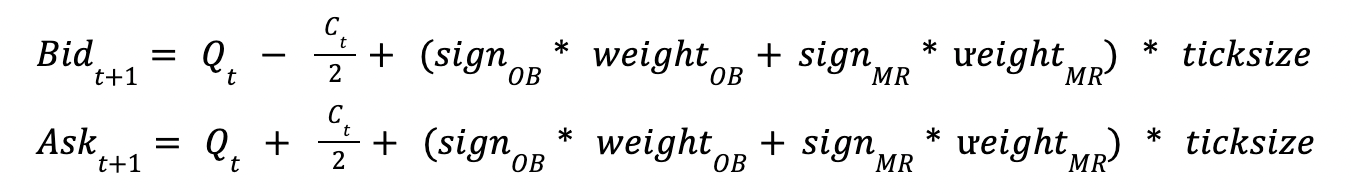

In [ ]:
tick_size = 0.05
weight_ob = 0.5
weight_mr = 0.5

# Skew spread based on the OB sign and MR sign
success_margin = subset_trade_df['spread'] + tick_size * (subset_trade_df['mr_sign'] * weight_mr + subset_trade_df['ob_sign'] * weight_ob)

# Separate buy and sell trades
buy_trades = subset_trade_df[subset_trade_df['side'] == 1]
sell_trades = subset_trade_df[subset_trade_df['side'] == -1]

# Ensure the indices of success_margin align with buy_trades and sell_trades
success_margin_buy = success_margin[buy_trades.index]
success_margin_sell = success_margin[sell_trades.index]

# Buy orders are successful if close to bid price
buy_successful = buy_trades[np.abs(buy_trades['price'] - buy_trades['fair_value']) <= success_margin_buy]
buy_successful = buy_successful[buy_successful['price'] <= buy_successful['fair_value']]

# Sell orders are successful if close to ask price
sell_successful = sell_trades[np.abs(sell_trades['price'] - sell_trades['fair_value']) <= success_margin_sell]
sell_successful = sell_successful[sell_successful['price'] >= sell_successful['fair_value']]

successful_trades = pd.concat([buy_successful, sell_successful])
successful_count = len(successful_trades)
avg_execution_price = successful_trades['price'].mean()


weight_ob = 0.5  -  weight_mr = 0.5

Successful Trades: 213
Average Execution Price: 2213.9764319248825


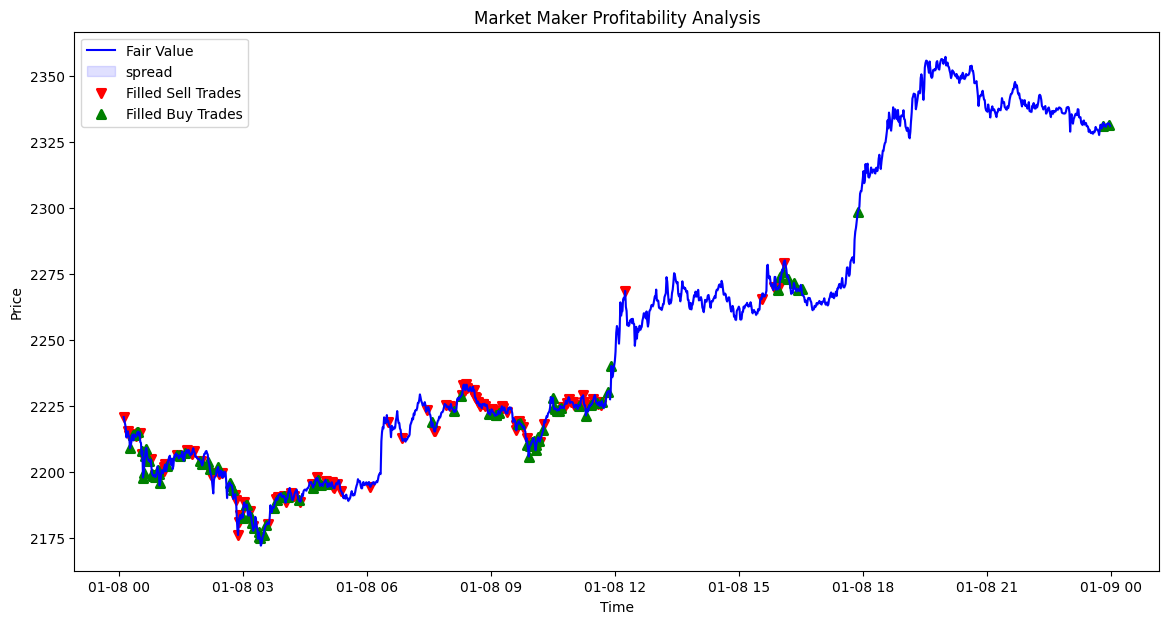

In [ ]:
print(f"Successful Trades: {successful_count}")
print(f"Average Execution Price: {avg_execution_price}")

plt.figure(figsize=(14, 7))
plt.plot(subset_trade_df.index, subset_trade_df['fair_value'], label='Fair Value', color='blue')
#plt.plot(subset_trade_df.index, theta * np.ones(shape = subset_trade_df.index.shape), label='Long term Mean', color='black', alpha=.2)
plt.fill_between(subset_trade_df.index,
                 subset_trade_df['fair_value'] - subset_trade_df['spread'],
                 subset_trade_df['fair_value'] + subset_trade_df['spread'],
                 color='blue', alpha=0.12, label='spread')
# plt.scatter(subset_trade_df.index, subset_trade_df['price'], label='Market Trades', color='blue', marker='x', alpha=.7)
# # comment
# plt.scatter(buy_trades.index, buy_trades['price'], label='Market Buy Trades', color='green', marker='x', alpha=.7)
# plt.scatter(sell_trades.index, sell_trades['price'], label='Market Sell Trades', color='red', marker='x', alpha=.7)
# # comment
plt.scatter(sell_successful.index, sell_successful['price'], label='Filled Sell Trades',
            color='red', marker='v', linewidths=2)
plt.scatter(buy_successful.index, buy_successful['price'], label='Filled Buy Trades',
            color='green', marker='^', linewidths=2)
plt.title('Market Maker Profitability Analysis')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Evaluate Portfolio

In [ ]:
def cal_PnL(trade_df, trade_successful):
    """Calculate the PnL of the Portfolio.
        - buy_successful = dataframe of the successful buy trades.
        - sell_successful = dataframe of the successful sell trades.
    Returns: merged_df with the following columns:
        - status:  at each time says if we are having long=1, short=-1 or we have no open positions = 0
        - cash: the cumulative amount of cash gained by the strategy.
    """

    # trade_successful = pd.concat([buy_successful, sell_successful]).sort_index()
    successfull_trade_index = trade_successful.index
    trade_successful.reset_index(drop=True, inplace=True)

    status = np.zeros(shape = len(trade_successful))
    cash = np.zeros(shape = len(trade_successful))
    invent = np.zeros(shape = len(trade_successful))

    # Iterating over the trade_successful dataframe rows
    for i, row in trade_successful.iterrows():
        if (i == 0) or (status[i - 1] == 0):
            if row['side'] == 1:
                status[i] = 1
                cash[i] -= row['price']
                invent[i] += 1
            elif row['side'] == -1:
                status[i] = -1
                cash[i] += row['price']
                invent[i] -= 1
        elif status[i - 1] == 1:
            if row['side'] == -1:
                status[i] = 0
                cash[i] += row['price']
                invent[i] -= 1
            elif row['side'] == 1:
                status[i] = 1
                cash[i] -= row['price']
                invent[i] += 1
        else:
            if row['side'] == -1:
                status[i] = -1
                cash[i] += row['price']
                invent[i] -= 1
            elif row['side'] == 1:
                status[i] = 0
                cash[i] -= row['price']
                invent[i] += 1

    if status[-1] == 1:
        cash[-1] += (trade_successful.iloc[-1]['price'] * invent[-1])
    if status[-1] == -1:
        cash[-1] -= (trade_successful.iloc[-1]['price'] * invent[-1])

    # Calculate status and cumulative cash
    cum_cash = cash.cumsum()

    # Create a DataFrame with the results using trade_successful's index
    pnl_df = pd.DataFrame({
        'status': status,
        'cumulative_cash': cum_cash
    }, index=successfull_trade_index)

    merged_df = trade_df.copy()
    merged_df = merged_df.merge(pnl_df, how='left', left_index=True, right_index=True)
    merged_df.fillna(method='ffill', inplace=True)
    merged_df.fillna(0, inplace=True)

    return merged_df


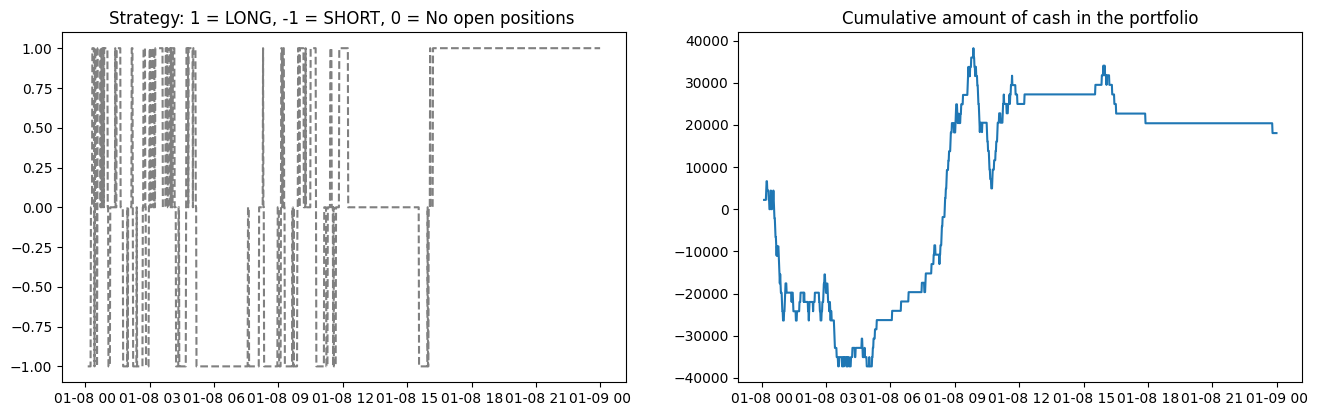

In [ ]:
trade_successful = pd.concat([buy_successful, sell_successful]).sort_index()
PnL_df = cal_PnL(subset_trade_df, trade_successful)

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(subset_trade_df.index, PnL_df['status'], linestyle="dashed", color="grey")
ax1.set_title("Strategy: 1 = LONG, -1 = SHORT, 0 = No open positions ")

ax2.plot(subset_trade_df.index, PnL_df['cumulative_cash'])
ax2.set_title("Cumulative amount of cash in the portfolio")

plt.show()

## Comparison with other Benchmark strategy

In [ ]:
data_ohlc = pd.read_csv('/content/openhighclose_ETHUSDT_day8.csv')
data_ohlc['start_at'] = pd.to_datetime(data_ohlc['start_at'])
data_ohlc.head()

,start_at,symbol,period,open,high,low,close
0,2024-01-08 00:00:00,ETHUSD,1,2222.42,2222.69,2220.07,2219.57
1,2024-01-08 00:01:00,ETHUSD,1,2220.77,2221.61,2220.66,2219.75
2,2024-01-08 00:02:00,ETHUSD,1,2220.95,2222.45,2220.95,2221.21
3,2024-01-08 00:03:00,ETHUSD,1,2222.41,2222.92,2220.89,2220.25
4,2024-01-08 00:04:00,ETHUSD,1,2221.45,2222.29,2221.41,2221.05


#### **1. EMA**

In [ ]:
df_ema2 = data_ohlc.copy()
df_ema2.set_index('start_at', inplace=True)

# Tính toán EMA
df_ema2['ema5'] = df_ema2['close'].ewm(span=5, adjust=False).mean()
df_ema2['ema20'] = df_ema2['close'].ewm(span=20, adjust=False).mean()

# Tạo cột ema_signal dựa trên sự cắt nhau giữa ema5 và ema20
df_ema2['ema_signal'] = 0  # Khởi tạo giá trị mặc định là 0 (không có tín hiệu)

# Điều kiện tạo tín hiệu mua (uptrend): EMA5 cắt lên EMA20
df_ema2.loc[(df_ema2['ema5'] > df_ema2['ema20']) & (df_ema2['ema5'].shift(1) <= df_ema2['ema20'].shift(1)), 'ema_signal'] = 1  # (uptrend)

# Điều kiện tạo tín hiệu bán (downtrend): EMA5 cắt xuống EMA20
df_ema2.loc[(df_ema2['ema5'] < df_ema2['ema20']) & (df_ema2['ema5'].shift(1) >= df_ema2['ema20'].shift(1)), 'ema_signal'] = 2  # (downtrend)

print(df_ema2.ema_signal.value_counts())
df_ema2.head()

ema_signal
0    1359
1      41
2      40
Name: count, dtype: int64


,symbol,period,open,high,low,close,ema5,ema20,ema_signal
start_at,,,,,,,,,
2024-01-08 00:00:00,ETHUSD,1,2222.42,2222.69,2220.07,2219.57,2219.570000,2219.570000,0
2024-01-08 00:01:00,ETHUSD,1,2220.77,2221.61,2220.66,2219.75,2219.630000,2219.587143,1
2024-01-08 00:02:00,ETHUSD,1,2220.95,2222.45,2220.95,2221.21,2220.156667,2219.741701,0
2024-01-08 00:03:00,ETHUSD,1,2222.41,2222.92,2220.89,2220.25,2220.187778,2219.790110,0
2024-01-08 00:04:00,ETHUSD,1,2221.45,2222.29,2221.41,2221.05,2220.475185,2219.910100,0


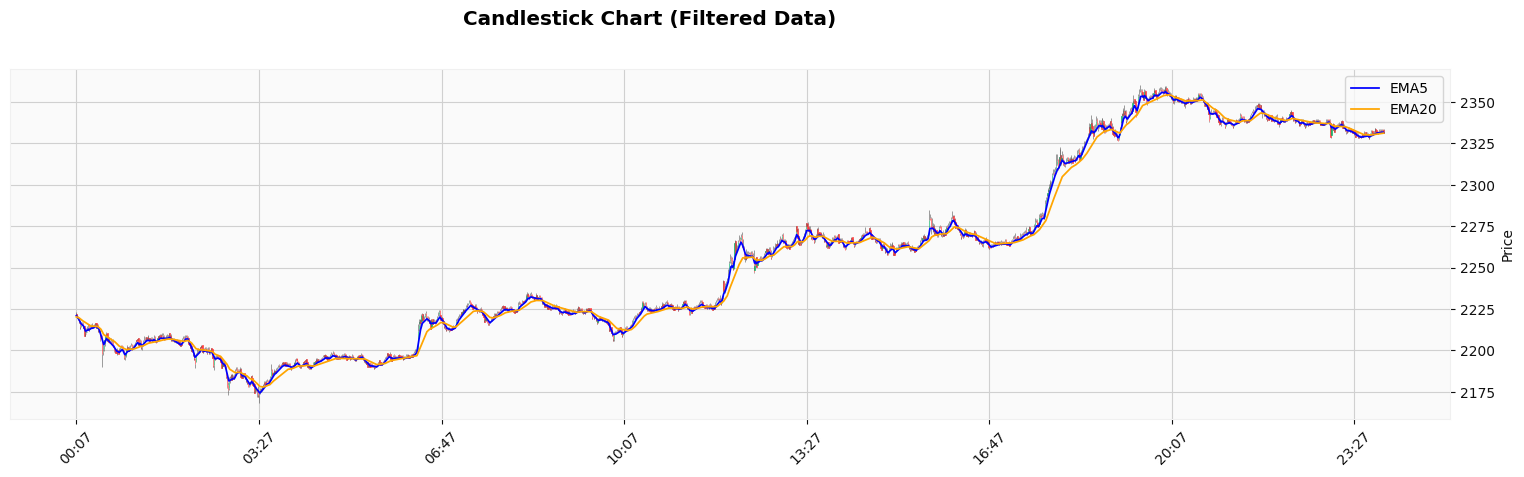

In [ ]:
# Define custom colors for uptrend, downtrend, and sideway based on ema_signal
color_map = {0: 'gray', 1: 'green', 2: 'red'}
df_ema2['color'] = df_ema2['ema_signal'].map(color_map)

# Prepare additional plots for ema5 and ema20
add_plots = [
    mpf.make_addplot(df_ema2['ema5'], color='blue', label='EMA5'),
    mpf.make_addplot(df_ema2['ema20'], color='orange', label='EMA20')
]

# Lọc dữ liệu trong một khoảng thời gian cụ thể
# start = '2024-01-08 07:00:00'
# end = '2024-01-08 08:00:00'
df_filtered = df_ema2.loc[subset_start:subset_end]  # Lọc dữ liệu từ ngày 2023-01-01 đến 2023-01-02

# Create candlestick chart with trend signals highlighted
mpf.plot(
    df_filtered,
    type='candle',
    style='yahoo',
    addplot=[
        mpf.make_addplot(df_filtered['ema5'], color='blue', label='EMA5'),
        mpf.make_addplot(df_filtered['ema20'], color='orange', label='EMA20')
    ],
    title='Candlestick Chart (Filtered Data)',
    ylabel='Price',
    volume=False,
    figsize=(20, 5),  # Kích thước biểu đồ
    warn_too_much_data=100000  # Tắt cảnh báo quá nhiều dữ liệu
)

In [ ]:
def plot_ema_signals(df, start, end):
    """
    Vẽ biểu đồ với EMA5, EMA20, giá đóng (close) và các tín hiệu mua/bán.
    Tín hiệu mua (buy) được đánh dấu bằng dấu ^ (green), tín hiệu bán (sell) được đánh dấu bằng dấu v (red).

    :param df: DataFrame chứa các cột 'ema5', 'ema20', 'close' và được xác định các tín hiệu mua/bán trong cột 'ema_signal'.
    """
    df = df.loc[start:end]

    # Lọc dữ liệu tín hiệu mua và bán
    buy_signals = df[df['ema_signal'] == 1]
    sell_signals = df[df['ema_signal'] == 2]

    # Vẽ biểu đồ
    plt.figure(figsize=(20, 6))

    # Vẽ EMA5 và EMA20
    plt.plot(df.index, df['ema5'], color='blue', label='EMA5')
    plt.plot(df.index, df['ema20'], color='orange', label='EMA20')

    # Vẽ đường giá đóng (close)
    plt.plot(df.index, df['close'], color='black', label='Close Price')

    # Vẽ dấu mua (buy) và bán (sell)
    plt.scatter(buy_signals.index, buy_signals['close'], color='green', marker='^', s=200, label='Buy Signal')
    plt.scatter(sell_signals.index, sell_signals['close'], color='red', marker='v', s=200, label='Sell Signal')

    # Thêm tiêu đề, nhãn và chú thích
    plt.title('EMA5 vs EMA20 with Buy and Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

    # Hiển thị biểu đồ
    plt.grid(True)
    plt.show()

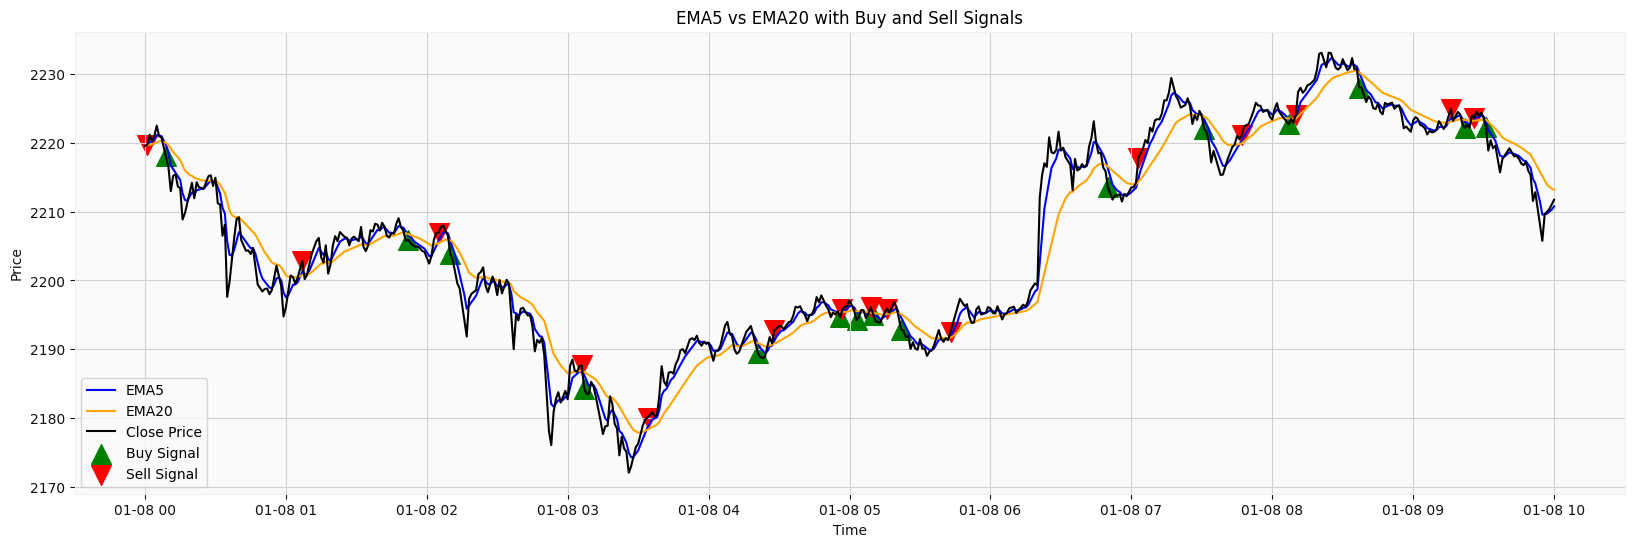

In [ ]:
# subset_start = '2024-01-08 00:00:00'
# subset_end = '2024-01-08 10:00:00'

plot_ema_signals(df_ema2, subset_start, subset_end)  # Gọi hàm để vẽ biểu đồ

In [ ]:
subset_start = '2024-01-08 00:07:00'
subset_end = '2024-01-08 23:59:00'

subset_df_ema2 = df_ema2.loc[subset_start:subset_end]
subset_trade_df = resampled_trade_df.loc[subset_start:subset_end]
subset_trade_df['side'] = np.where(subset_trade_df['side'] == 'buy', 1, -1)

# add the 'ema_signal' column from df to trade_df
subset_trade_df['ema_signal'] = subset_df_ema2['ema_signal'].values

# Separate buy and sell trades
buy_trades = subset_trade_df[subset_trade_df['side'] == 1]
sell_trades = subset_trade_df[subset_trade_df['side'] == -1]

# Buy orders are successful if 'ema_signal' = 1  -> tin hieu ban theo EMA nen tim cac lenh buy trade de fill
buy_successful = buy_trades[buy_trades['ema_signal'] == 1]

# Buy orders are successful if 'ema_signal' = 2  -> tin hieu mua theo EMA nen tim cac lenh sell trade de fill
sell_successful = sell_trades[sell_trades['ema_signal'] == 2]

successful_trades = pd.concat([buy_successful, sell_successful])
successful_count = len(successful_trades)
avg_execution_price = successful_trades['price'].mean()

Successful Trades: 37
Average Execution Price: 2252.358378378379


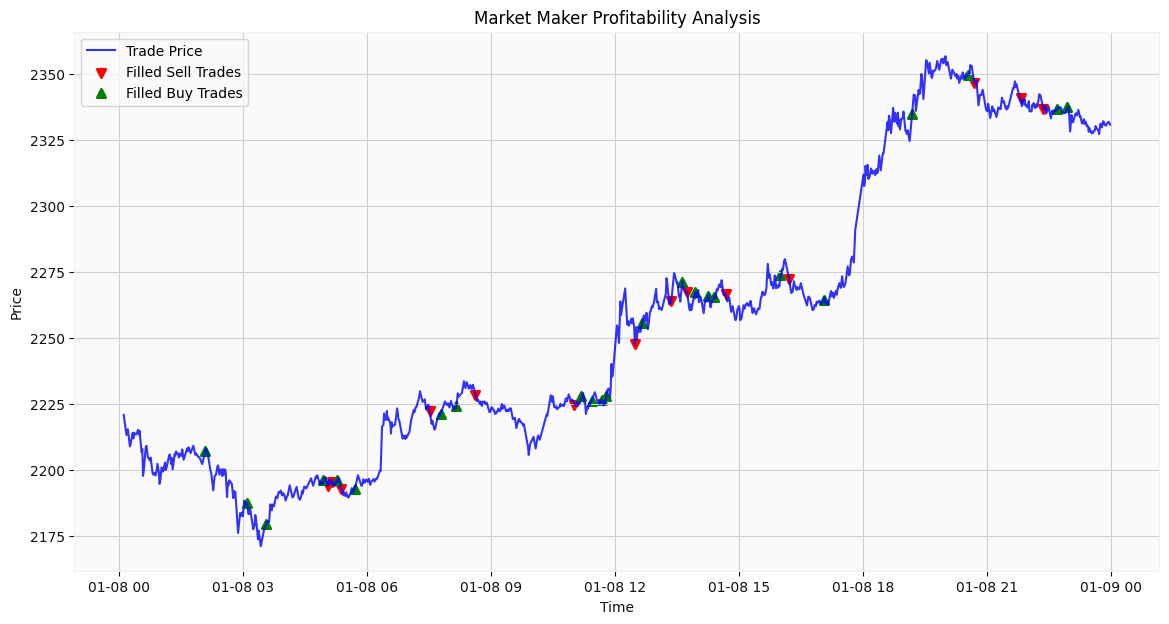

In [ ]:
print(f"Successful Trades: {successful_count}")
print(f"Average Execution Price: {avg_execution_price}")

plt.figure(figsize=(14, 7))
plt.plot(subset_trade_df.index, subset_trade_df['price'], color='blue', label='Trade Price', alpha=.8)
# plt.scatter(subset_trade_df.index, subset_trade_df['price'], label='Market Trades', color='blue', marker='x', alpha=.7)
# # comment
# plt.scatter(buy_trades.index, buy_trades['price'], label='Market Buy Trades', color='green', marker='x', alpha=.7)
# plt.scatter(sell_trades.index, sell_trades['price'], label='Market Sell Trades', color='red', marker='x', alpha=.7)
# # comment
plt.scatter(sell_successful.index, sell_successful['price'], label='Filled Sell Trades',
            color='red', marker='v', linewidths=2)
plt.scatter(buy_successful.index, buy_successful['price'], label='Filled Buy Trades',
            color='green', marker='^', linewidths=2)
plt.title('Market Maker Profitability Analysis')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

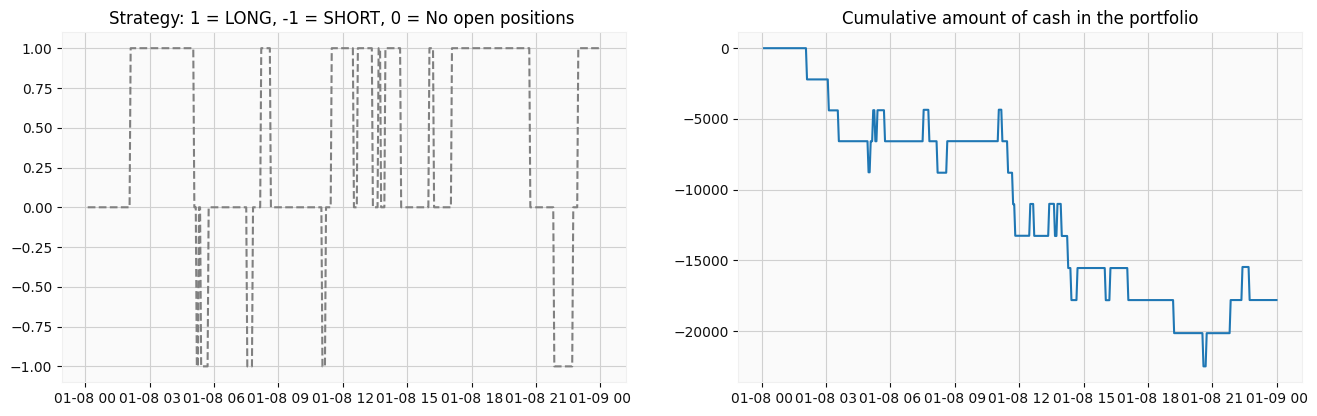

In [ ]:
trade_successful = pd.concat([buy_successful, sell_successful]).sort_index()
PnL_df = cal_PnL(subset_trade_df, trade_successful)

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(subset_trade_df.index, PnL_df['status'], linestyle="dashed", color="grey")
ax1.set_title("Strategy: 1 = LONG, -1 = SHORT, 0 = No open positions ")

ax2.plot(subset_trade_df.index, PnL_df['cumulative_cash'])
ax2.set_title("Cumulative amount of cash in the portfolio")

plt.show()

#### **2. Z-score**

In [ ]:
# Giả sử bạn có một DataFrame với dữ liệu giá
df_zscore= data_ohlc.copy()
df_zscore.set_index('start_at', inplace=True)

# Tính toán trung bình và độ lệch chuẩn trong khoảng thời gian 20 ngày
window = 20
df_zscore['sma20'] = df_zscore['close'].rolling(window=window).mean()
df_zscore['std20'] = df_zscore['close'].rolling(window=window).std()

# Tính Z-score
df_zscore['zscore'] = (df_zscore['close'] - df_zscore['sma20']) / df_zscore['std20']

# Tạo tín hiệu giao dịch
n_std=1.25
def create_signal(row):
    if row['zscore'] < -n_std:
        return 1  # Tín hiệu mua
    elif row['zscore'] > n_std:
        return 2  # Tín hiệu bán
    return 0  # Không có tín hiệu

df_zscore['zscore_signal'] = df_zscore.apply(create_signal, axis=1)
# df_zscore.dropna(inplace=True, axis=0)

# In kết quả
print(df_zscore.zscore_signal.value_counts())
df_zscore.tail()

zscore_signal
0    883
2    331
1    226
Name: count, dtype: int64


,symbol,period,open,high,low,close,sma20,std20,zscore,zscore_signal
start_at,,,,,,,,,,
2024-01-08 23:55:00,ETHUSD,1,2332.98,2333.60,2332.69,2332.08,2330.5515,1.254823,1.218100,0
2024-01-08 23:56:00,ETHUSD,1,2333.28,2333.76,2332.98,2332.03,2330.7145,1.222549,1.076030,0
2024-01-08 23:57:00,ETHUSD,1,2333.23,2333.91,2332.96,2332.22,2330.8640,1.214250,1.116738,0
2024-01-08 23:58:00,ETHUSD,1,2333.42,2333.80,2332.78,2331.65,2330.9035,1.226897,0.608445,0
2024-01-08 23:59:00,ETHUSD,1,2332.85,2333.60,2332.19,2331.15,2330.9545,1.214186,0.161013,0


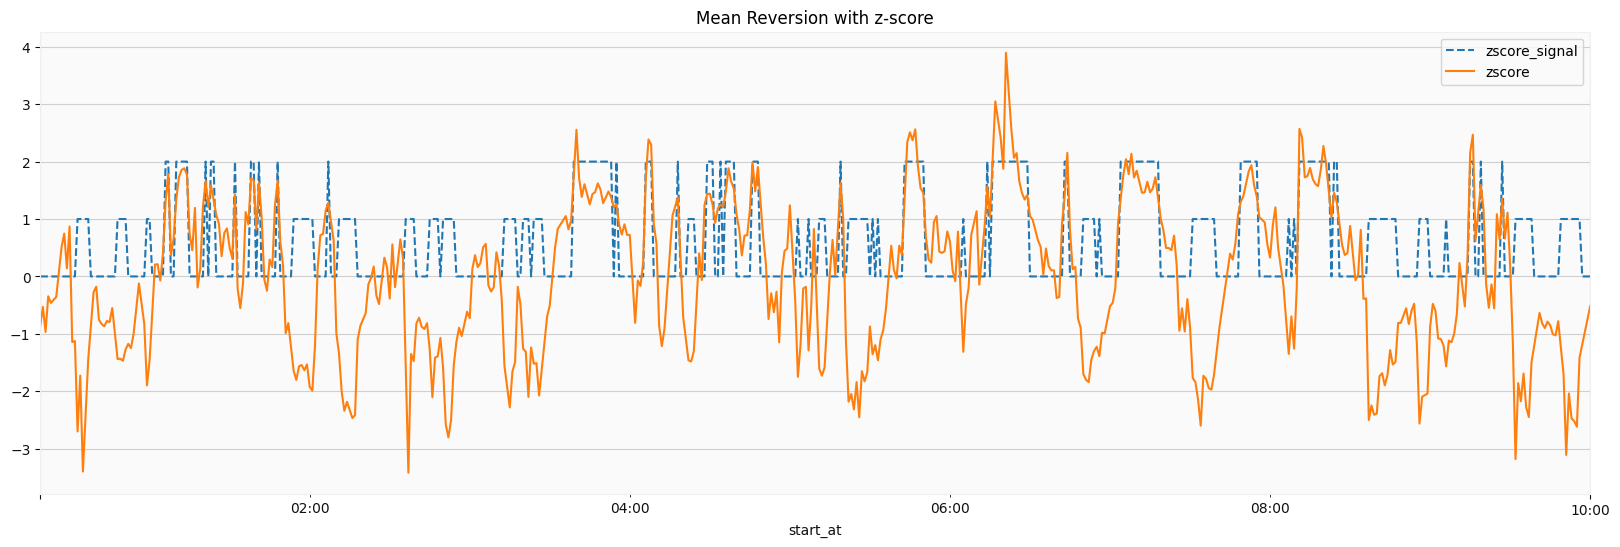

In [ ]:
# Lọc dữ liệu theo khoảng thời gian
plt_df = df_zscore.dropna(axis=0).loc[subset_start:subset_end]

figs=(20,6)
plt_df['zscore_signal'].plot(figsize=figs, linestyle="--")
plt_df['zscore'].plot(figsize=figs)
plt.title("Mean Reversion with z-score")
plt.legend()
plt.show()

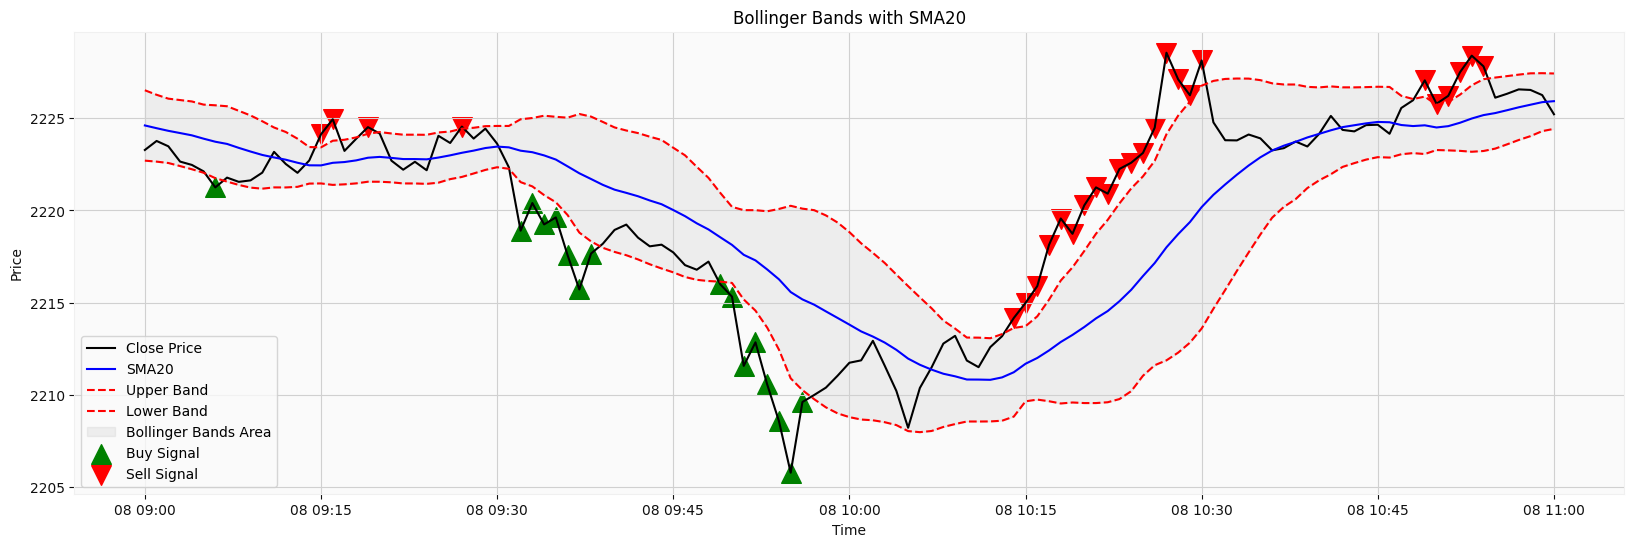

In [ ]:
subset_start = '2024-01-08 09:00:00'
subset_end = '2024-01-08 11:00:00'

# Tính Upper and Lower Bollinger Bands
n_std = 1.25  # Số lần độ lệch chuẩn
df_zscore['upper_band'] = df_zscore['sma20'] + n_std * df_zscore['std20']
df_zscore['lower_band'] = df_zscore['sma20'] - n_std * df_zscore['std20']

# Lọc dữ liệu theo khoảng thời gian
plt_df = df_zscore.dropna(axis=0).loc[subset_start:subset_end]

# Vẽ biểu đồ
plt.figure(figsize=(20, 6))

# Vẽ đường giá đóng
plt.plot(plt_df.index, plt_df['close'], color='black', label='Close Price')

# Vẽ SMA20
plt.plot(plt_df.index, plt_df['sma20'], color='blue', label='SMA20')

# Vẽ Upper and Lower Bollinger Bands
plt.plot(plt_df.index, plt_df['upper_band'], color='red', linestyle='--', label='Upper Band')
plt.plot(plt_df.index, plt_df['lower_band'], color='red', linestyle='--', label='Lower Band')

# Vẽ phần fill giữa lower_band và upper_band
plt.fill_between(plt_df.index, plt_df['lower_band'], plt_df['upper_band'], color='gray', alpha=0.1, label='Bollinger Bands Area')

# Vẽ marker cho tín hiệu mua và bán
buy_signals = plt_df[plt_df['zscore_signal'] == 1]  # Tín hiệu mua
sell_signals = plt_df[plt_df['zscore_signal'] == 2]  # Tín hiệu bán

# Vẽ marker cho tín hiệu mua (buy)
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1, s=200)

# Vẽ marker cho tín hiệu bán (sell)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1, s=200)

# Thêm tiêu đề, nhãn và chú thích
plt.title('Bollinger Bands with SMA20')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# plt.grid(True)
plt.show()

In [ ]:
subset_start = '2024-01-08 00:07:00'
subset_end = '2024-01-08 23:59:00'

subset_df_zscore = df_zscore.loc[subset_start:subset_end]
subset_trade_df = resampled_trade_df.loc[subset_start:subset_end]
subset_trade_df['side'] = np.where(subset_trade_df['side'] == 'buy', 1, -1)

# add the 'ema_signal' column from df to trade_df
subset_trade_df['zscore_signal'] = subset_df_zscore['zscore_signal'].values

# Separate buy and sell trades
buy_trades = subset_trade_df[subset_trade_df['side'] == 1]
sell_trades = subset_trade_df[subset_trade_df['side'] == -1]

# Buy orders are successful if 'ema_signal' = 1  -> tin hieu ban theo EMA nen tim cac lenh buy trade de fill
buy_successful = buy_trades[buy_trades['zscore_signal'] == 1]

# Buy orders are successful if 'ema_signal' = 2  -> tin hieu mua theo EMA nen tim cac lenh sell trade de fill
sell_successful = sell_trades[sell_trades['zscore_signal'] == 2]

successful_trades = pd.concat([buy_successful, sell_successful])
successful_count = len(successful_trades)
avg_execution_price = successful_trades['price'].mean()

Successful Trades: 284
Average Execution Price: 2261.0354225352116


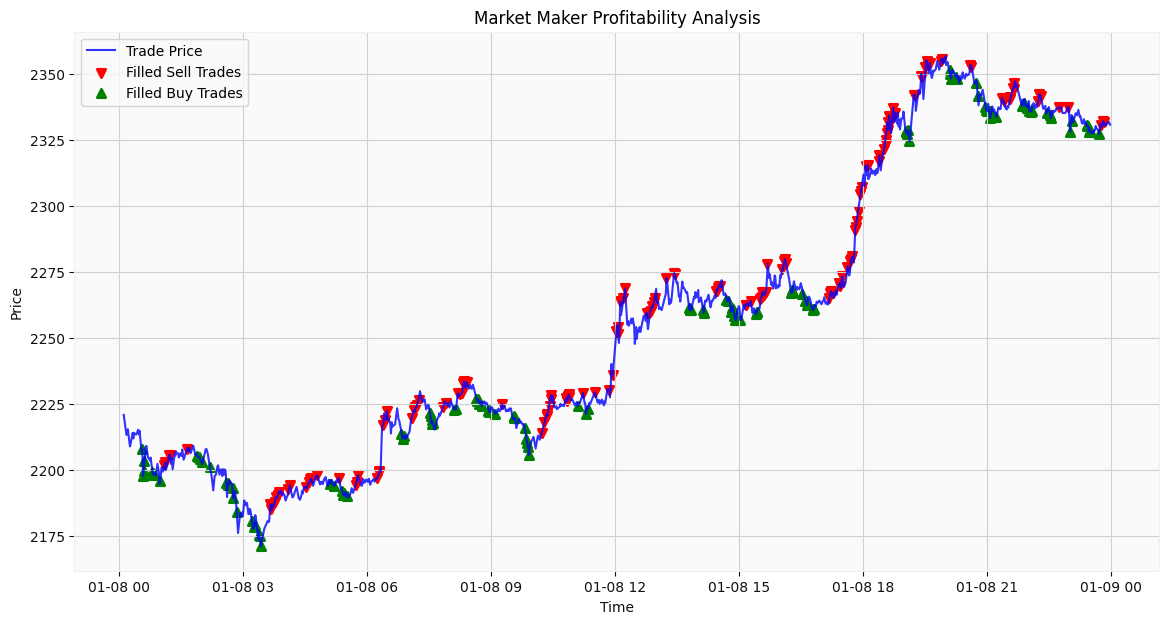

In [ ]:
print(f"Successful Trades: {successful_count}")
print(f"Average Execution Price: {avg_execution_price}")

plt.figure(figsize=(14, 7))
plt.plot(subset_trade_df.index, subset_trade_df['price'], color='blue', label='Trade Price', alpha=.8)
# plt.scatter(subset_trade_df.index, subset_trade_df['price'], label='Market Trades', color='blue', marker='x', alpha=.7)
# # comment
# plt.scatter(buy_trades.index, buy_trades['price'], label='Market Buy Trades', color='green', marker='x', alpha=.7)
# plt.scatter(sell_trades.index, sell_trades['price'], label='Market Sell Trades', color='red', marker='x', alpha=.7)
plt.scatter(sell_successful.index, sell_successful['price'], label='Filled Sell Trades',
            color='red', marker='v', linewidths=2)
plt.scatter(buy_successful.index, buy_successful['price'], label='Filled Buy Trades',
            color='green', marker='^', linewidths=2)
plt.title('Market Maker Profitability Analysis')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

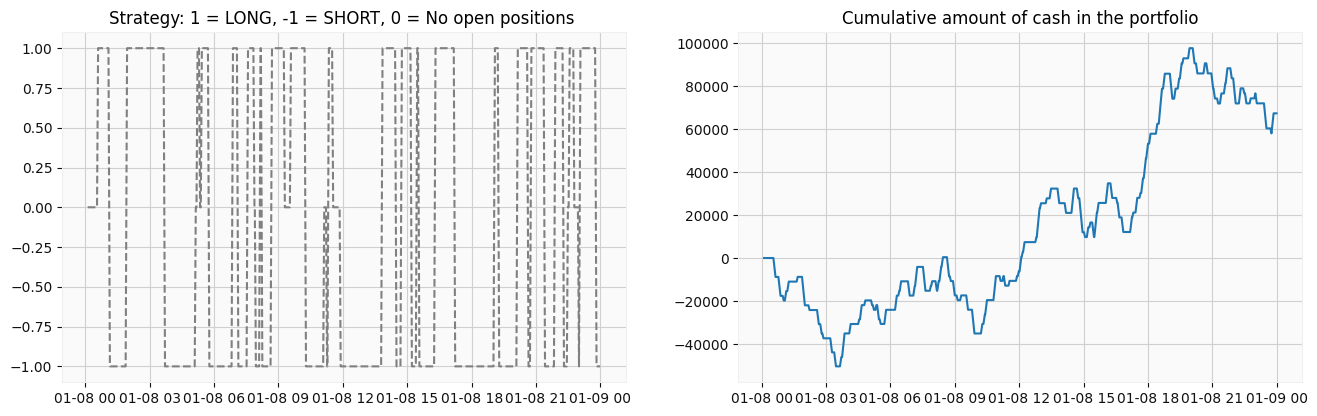

In [ ]:
trade_successful = pd.concat([buy_successful, sell_successful]).sort_index()
PnL_df = cal_PnL(subset_trade_df, trade_successful)

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(subset_trade_df.index, PnL_df['status'], linestyle="dashed", color="grey")
ax1.set_title("Strategy: 1 = LONG, -1 = SHORT, 0 = No open positions ")

ax2.plot(subset_trade_df.index, PnL_df['cumulative_cash'])
ax2.set_title("Cumulative amount of cash in the portfolio")

plt.show()